In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import pandas as pd

/tmp/ipykernel_59879/671612114.py:6: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
SEED = 42
DIMENSIONS = (28, 28)
CHANNELS = 1  # grayscale
INPUT_SIZE = DIMENSIONS[0] * DIMENSIONS[1]
OUTPUT_SIZE = 10

def transform_data(
        is_convolutional: bool,
        x: pd.DataFrame,
        y: pd.Series | None = None) -> tuple[np.array, np.array]:
    """
    Transforms the data. Returns a tuple of (x, y) where x is a tensor of the features and y is a
    tensor of the labels.

    Args:
        is_convolutional: A boolean indicating whether the model is convolutional.
        x: A dataframe of the features.
        y: A series of the labels.
    """
    x = x.to_numpy()
    # Normalize the tensor
    x_min = x.min()
    x_max = x.max()
    x = (x - x_min) / (x_max - x_min)
    assert x.min() == 0
    assert x.max() == 1
    if is_convolutional:
        # Reshape data to have channel dimension
        # MNIST images are 28x28, so we reshape them to [batch_size, 1, 28, 28]
        x = x.reshape(-1, CHANNELS, DIMENSIONS[0], DIMENSIONS[1])
    if y is not None:
        y = y.to_numpy().astype(int)
    return x, y


def get_data():  # noqa
    """Function is required by and called from `model_pipeline()`."""
    x, y = fetch_openml('mnist_784', version=1, return_X_y=True, parser='auto')
    x, y = transform_data(is_convolutional=False, x=x, y=y)
    # 80% train; 10% validation; 10% test
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=SEED)
    x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5, random_state=SEED)  # noqa
    print(f"Training set  : X-{x_train.shape}, y-{y_train.shape}")
    print(f"Validation set: X-{x_val.shape}, y-{y_val.shape}")
    print(f"Test set      : X-{x_test.shape}, y-{y_test.shape}")
    return x_train, x_val, x_test, y_train, y_val, y_test

x_train, x_val, x_test, y_train, y_val, y_test = get_data()

Training set  : X-(56000, 784), y-(56000,)
Validation set: X-(7000, 784), y-(7000,)
Test set      : X-(7000, 784), y-(7000,)


In [4]:
from torchpy import net
import torchpy.architectures as arch

learning_rate = 0.01
epochs = 15
batch_size = 32

rng = np.random.default_rng(SEED)
shuffle_index = rng.permutation(x_train.shape[0])
x_train, y_train = x_train[shuffle_index], y_train[shuffle_index]

# model = net.Sequential([
#     net.Linear(INPUT_SIZE, 100, weight_init_scale=net.he_init_scale),
#     net.BatchNorm(100),
#     net.ReLU(),
#     net.Linear(100, OUTPUT_SIZE, weight_init_scale=net.glorot_init_scale),
# ])
model = arch.MLP(INPUT_SIZE, OUTPUT_SIZE, hidden_features=[100, 50])

# Loss function and optimizer
loss_function = net.CrossEntropyLoss()
optimizer = net.SGD(learning_rate=learning_rate)

training_losses = []
validation_losses = []

start = time.time()
for epoch in range(epochs):
    for batch, i in enumerate(range(0, x_train.shape[0], batch_size)):
        x_batch = x_train[i:i+batch_size]
        y_batch = y_train[i:i+batch_size]
        with net.training_mode():
            # Forward pass
            logits = model(x_batch)
            loss = loss_function(logits, y_batch)
            # Backward pass
            loss_grad = loss_function.backward()
            model.backward(loss_grad)
            model.step(optimizer)
        if batch % 400 == 0:
            training_losses.append(loss)
            # calculate validation loss
            val_loss = loss_function(logits=model(x_val), targets=y_val)
            validation_losses.append(val_loss)
            print(f"Epoch {epoch}, Batch {batch:04}, training loss {round(loss, 3)}, validation loss {round(val_loss, 3)}")  # noqa

end = time.time()

Epoch 0, Batch 0000, training loss 2.875, validation loss 2.387
Epoch 0, Batch 0400, training loss 0.234, validation loss 0.416
Epoch 0, Batch 0800, training loss 0.302, validation loss 0.304
Epoch 0, Batch 1200, training loss 0.297, validation loss 0.257
Epoch 0, Batch 1600, training loss 0.338, validation loss 0.227
Epoch 1, Batch 0000, training loss 0.299, validation loss 0.222
Epoch 1, Batch 0400, training loss 0.116, validation loss 0.202
Epoch 1, Batch 0800, training loss 0.174, validation loss 0.187
Epoch 1, Batch 1200, training loss 0.23, validation loss 0.178
Epoch 1, Batch 1600, training loss 0.222, validation loss 0.169
Epoch 2, Batch 0000, training loss 0.209, validation loss 0.168
Epoch 2, Batch 0400, training loss 0.083, validation loss 0.161
Epoch 2, Batch 0800, training loss 0.136, validation loss 0.153
Epoch 2, Batch 1200, training loss 0.192, validation loss 0.15
Epoch 2, Batch 1600, training loss 0.174, validation loss 0.145
Epoch 3, Batch 0000, training loss 0.17, v

In [5]:
print(f"Training took {round(end - start, 2)} seconds on via torchpy")

Training took 89.97 seconds on via torchpy


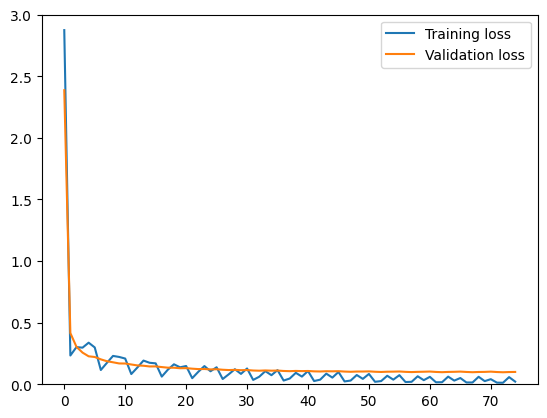

In [6]:
# plot losses over time
plt.plot(training_losses, label="Training loss")
plt.plot(validation_losses, label="Validation loss")
plt.ylim(0, 3)
plt.legend()

In [7]:
logits = model(x_test)
loss = loss_function(logits, y_test)
print(f"Test loss: {loss}")
# get index of highest probability in each row
predicted = np.argmax(logits, axis=1)
accuracy = (predicted == y_test).sum() / y_test.size
print(f"Test accuracy: {accuracy:.3f}")

Test loss: 0.11637274478383271
Test accuracy: 0.967


Text(0.5, 1.0, 'Count of Misclassified Samples by Class')

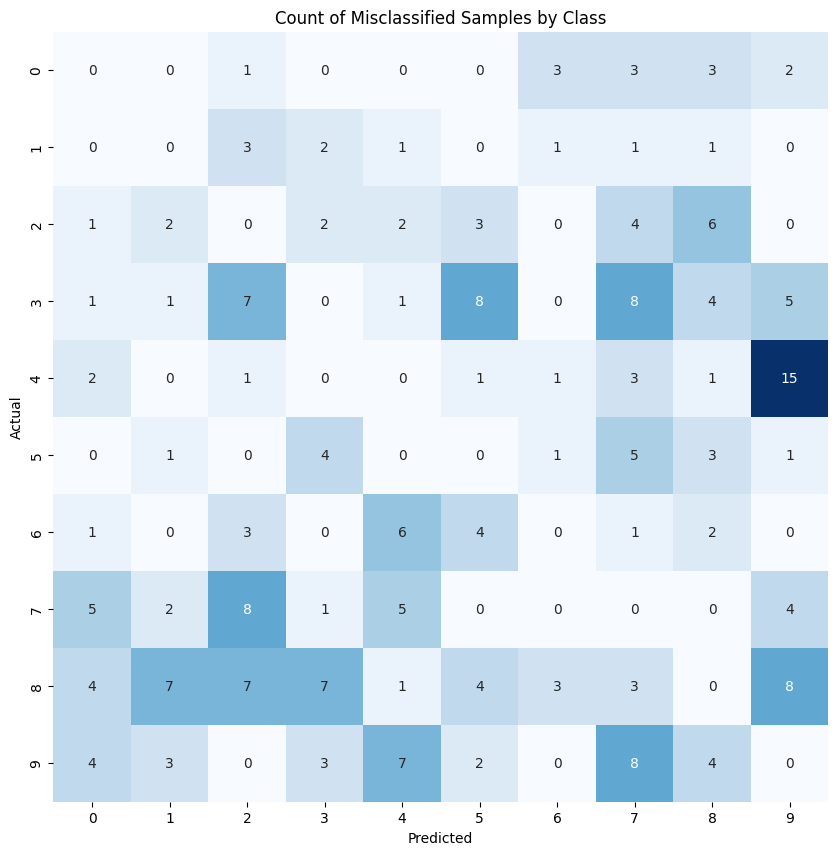

In [8]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, predicted)
# remove the diagonal values (correct predictions) for better visualization
np.fill_diagonal(cm, 0)
fig = plt.figure(figsize=(OUTPUT_SIZE, OUTPUT_SIZE))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Count of Misclassified Samples by Class')

---